# Imports

In [2]:
!pip install beautifulsoup4

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import spacy
import re,string,unicodedata
from nltk.corpus import sentiwordnet as swn
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from textblob import TextBlob
from textblob import Word
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
import warnings
from nltk import bigrams
warnings.filterwarnings('ignore')

# Import dataset

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')


# data_path = "/content/sample_data/IMDB Dataset.csv"
# df = pd.read_csv(data_path)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
data_path = "/content/drive/MyDrive/document_classification/IMDB Dataset.csv"
df = pd.read_csv(data_path)

# Text pre-processing and exploration

In [6]:
df.shape

(50000, 2)

In [7]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [8]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,negative
freq,5,25000


In [9]:
df['sentiment'].value_counts()

negative    25000
positive    25000
Name: sentiment, dtype: int64

The data is balanced.

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


No missing values

## Cleaning the dataset

In [11]:
#Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text

#Apply function on review column
df['review']=df['review'].apply(denoise_text)

In [12]:
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,' ',text)
    return text

#Apply function on review column
df['review']=df['review'].apply(remove_special_characters)

## Removing stop words

In [13]:
nltk.download('stopwords')
tokenizer=ToktokTokenizer()
stopword_list=nltk.corpus.stopwords.words('english')

def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

#Apply function on review column
df['review']=df['review'].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Stemming

In [14]:
#Stemming the text
org_df = df
def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text

#Apply function on review column
df['review']=df['review'].apply(simple_stemmer)

## 10 most common words by category

In [15]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words

positive_rev = df[df['sentiment'] == 'positive']['review']
negative_rev = df[df['sentiment'] == 'negative']['review']

positive_words = get_corpus(positive_rev)
negative_words = get_corpus(negative_rev)

In [16]:
from collections import Counter

positive_counter = Counter(positive_words)
negative_counter = Counter(negative_words)

positive_most_common = positive_counter.most_common(10)
negative_most_common = negative_counter.most_common(10)
positive_most_common = dict(positive_most_common)
negative_most_common = dict(negative_most_common)

In [66]:
print(positive_counter)

Counter({'film': 50874, 'movi': 44832, 'one': 28280, 'like': 20555, 'time': 16621, 'good': 15257, 'see': 15134, 'stori': 14185, 'charact': 14020, 'make': 13809, 'great': 13124, 'well': 13072, 'watch': 12903, 'get': 12691, 'love': 12459, 'show': 11078, 'also': 10789, 'realli': 10735, 'would': 10594, 'play': 10063, 'scene': 10055, 'even': 9914, 'end': 9284, 'first': 9231, 'much': 9199, 'way': 8861, 'peopl': 8829, 'best': 8521, 'think': 8484, 'look': 8170, 'life': 8144, 'go': 7982, 'year': 7815, 'mani': 7662, 'work': 7624, 'made': 7350, 'know': 7255, 'two': 7162, 'perform': 7064, 'thing': 7034, 'act': 6903, 'take': 6846, 'man': 6817, 'seen': 6760, 'come': 6726, 'say': 6659, 'still': 6461, 'littl': 6458, 'never': 6333, 'actor': 6312, 'could': 6262, 'seem': 6122, 'find': 5997, 'want': 5982, 'give': 5829, 'feel': 5691, 'enjoy': 5548, 'ever': 5450, 'part': 5366, 'live': 5360, 'music': 5314, 'plot': 5136, 'role': 5124, 'back': 5121, 'real': 5117, 'lot': 5077, 'use': 4933, 'tri': 4916, 'world':

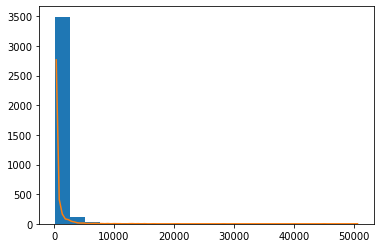

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import pylab as p
pos_data = list(positive_counter.values())

pos_data_cutoff = list([i for i in pos_data if i > 100])
# print(a)
plt.hist(pos_data_cutoff,bins=20)
y,binEdges=np.histogram(pos_data_cutoff,bins=100)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
p.plot(bincenters,y,'-')
p.show()




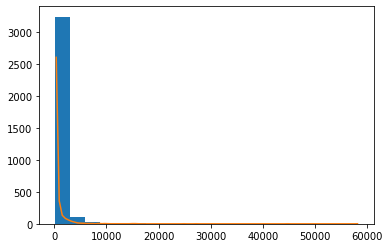

In [37]:
neg_data = list(negative_counter.values())

neg_data_cutoff = list([i for i in neg_data if i > 100])
# print(a)
plt.hist(neg_data_cutoff,bins=20)
y,binEdges=np.histogram(neg_data_cutoff,bins=100)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
p.plot(bincenters,y,'-')
p.show()

In [62]:
pd.DataFrame(positive_most_common.items(), columns=['word','total'])

,word,total
0,film,50874
1,movi,44832
2,one,28280
3,like,20555
4,time,16621
5,good,15257
6,see,15134
7,stori,14185
8,charact,14020
9,make,13809


In [63]:
pd.DataFrame(negative_most_common.items(), columns=['word','total'])

,word,total
0,movi,58398
1,film,44973
2,one,27150
3,like,24640
4,make,16208
5,even,15429
6,time,15327
7,get,15269
8,watch,14967
9,good,14922


#bigrams

In [18]:
pos_terms_bigram = bigrams(positive_words)
neg_terms_bigram = bigrams(negative_words)

positive_counter_bigram = Counter(pos_terms_bigram)
negative_counter_bigram = Counter(neg_terms_bigram)

positive_most_common_bigram = positive_counter_bigram.most_common(10)
negative_most_common_bigram = negative_counter_bigram.most_common(10)
positive_most_common_bigram = dict(positive_most_common_bigram)
negative_most_common_bigram = dict(negative_most_common_bigram)

In [19]:
#positive_most_common_bigram

In [20]:
#negative_most_common_bigram

positive bigrams

In [64]:
pd.DataFrame(positive_most_common_bigram.items(), columns=['bigram','total'])

,bigram,total
0,"(one, best)",1676
1,"(watch, movi)",1318
2,"(even, though)",1100
3,"(year, old)",1078
4,"(see, movi)",994
5,"(ever, seen)",976
6,"(first, time)",963
7,"(look, like)",939
8,"(highli, recommend)",888
9,"(new, york)",854


negative bigrams

In [65]:
pd.DataFrame(negative_most_common_bigram.items(), columns=['bigram','total'])

,bigram,total
0,"(look, like)",2782
1,"(watch, movi)",1816
2,"(ever, seen)",1731
3,"(wast, time)",1684
4,"(special, effect)",1490
5,"(movi, ever)",1341
6,"(year, old)",1285
7,"(bad, movi)",1259
8,"(low, budget)",1254
9,"(movi, like)",1118


## Encoding the target

In [23]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()

df['sentiment']=le.fit_transform(df['sentiment'])

## Splitting the dataset

In [24]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df['review'], df['sentiment'], test_size=0.4, random_state=42)

## Bag of words

In [25]:
#Count vectorizer for bag of words
cv=CountVectorizer(min_df=0,max_df=1,binary=False,ngram_range=(1,2))
#transformed train reviews
cv_train_reviews=cv.fit_transform(x_train)
#transformed test reviews
cv_test_reviews=cv.transform(x_test)

print('BOW_cv_train:',cv_train_reviews.shape)
print('BOW_cv_test:',cv_test_reviews.shape)

BOW_cv_train: (30000, 1398131)
BOW_cv_test: (20000, 1398131)


## Tfidf

In [26]:
#Tfidf vectorizer
tv=TfidfVectorizer(min_df=0,max_df=1,use_idf=True,ngram_range=(1,2))
#transformed train reviews
tv_train_reviews=tv.fit_transform(x_train)
#transformed test reviews
tv_test_reviews=tv.transform(x_test)
print('Tfidf_train:',tv_train_reviews.shape)
print('Tfidf_test:',tv_test_reviews.shape)

Tfidf_train: (30000, 1398131)
Tfidf_test: (20000, 1398131)


# Unsupervised learning

In [27]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

reviews = org_df['review']
print(reviews)
taggedlist=[]
for review in reviews:
  sentences = nltk.sent_tokenize(review)
  stokens = [nltk.word_tokenize(sent) for sent in sentences]
  for stoken in stokens:        
     taggedlist.append(nltk.pos_tag(stoken))

#print(sentences)
#print(stokens)  

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
0        one review mention watch 1 Oz episod hook righ...
1        wonder littl product film techniqu unassum old...
2        thought wonder way spend time hot summer weeke...
3        basic famili littl boy jake think zombi closet...
4        petter mattei love time money visual stun film...
                               ...                        
49995    thought movi right good job creativ origin fir...
49996    bad plot bad dialogu bad act idiot direct anno...
49997    cathol taught parochi elementari school nun ta...
49998    go disagre previou comment side maltin one sec...
49999    one expect star trek movi high art fan expect ...
Name: review, Length: 50000, dtype: object
['one expect star trek movi high art fan 

In [28]:
#print(taggedlist[0])

In [29]:
nltk.download('sentiwordnet')
nltk.download('wordnet')

wnl = nltk.WordNetLemmatizer()
score_list=[]
for idx,taggedsent in enumerate(taggedlist):  #iterate over all tokens
    score_list.append([])
    for idx2,t in enumerate(taggedsent):  #t[0] word, t[1] pos tag
        newtag=''
        lemmatized=wnl.lemmatize(t[0])
        if t[1].startswith('NN'):
            newtag='n'
        elif t[1].startswith('JJ'):
            newtag='a'
        elif t[1].startswith('V'):
            newtag='v'
        elif t[1].startswith('R'):
            newtag='r'
        else:
            newtag=''       
        if(newtag!=''):    
            synsets = list(swn.senti_synsets(lemmatized, newtag))
            #synsets contains for each token the probability for negative, positive and objective
            #Getting average of all possible sentiments, as you requested        
            score=0
            if(len(synsets)>0):
                for syn in synsets:
                    score+=syn.pos_score()-syn.neg_score()
                score_list[idx].append(score/len(synsets))

[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/sentiwordnet.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [30]:
print(score_list[0])

[0.025, 0.16666666666666666, 0.0, 0.03125, 0.1125, -0.1, 0.10416666666666667, -0.020833333333333332, -0.011904761904761904, -0.4375, -0.0625, 0.035, 0.1125, 0.0, 0.0, 0.16666666666666666, 0.03125, -0.10416666666666667, 0.1, 0.375, 0.03125, 0.0, -0.0625, 0.125, 0.05357142857142857, 0.0, 0.009615384615384616, 0.005681818181818182, 0.25, 0.0, 0.08928571428571429, 0.0, 0.008928571428571428, -0.0625, 0.0, 0.0, 0.0, -0.019230769230769232, 0.10714285714285714, 0.0, 0.0, 0.027777777777777776, 0.0, 0.0, 0.0, 0.0, 0.1875, 0.0, 0.0, -0.140625, 0.0, 0.0, 0.020833333333333332, -0.375, 0.025, -0.056818181818181816, 0.011363636363636364, 0.08333333333333333, 0.125, 0.03125, 0.125, 0.09375, 0.03125, -0.125, 0.0, 0.0, 0.25, -0.10416666666666667, 0.10416666666666667, 0.0, 0.04, -0.375, 0.011363636363636364, 0.0, 0.023809523809523808, 0.010416666666666666, 0.10714285714285714, -0.03125, 0.175, -0.08333333333333333, 0.0, -0.015625, 0.0, 0.016666666666666666, 0.010416666666666666, -0.056818181818181816, 0.

In [31]:
sentence_sentiment=[]
for score_sent in score_list:
    sentence_sentiment.append(sum([word_score for word_score in score_sent])/len(score_sent))

In [32]:
#print(sentence_sentiment)
#print(len(sentence_sentiment))
#print(sentence_sentiment)
def Average(lst): 
    return sum(lst) / len(lst)
rounded = []
avg = Average(sentence_sentiment)
for num in sentence_sentiment:
  if num > avg:
    rounded.append(1)
  else:
    rounded.append(0)
#print(rounded)

In [33]:
accuracy_score(org_df['sentiment'],rounded)

0.65424

# supervised learning

## SVM

### SVM with bag of words

In [34]:
from sklearn.linear_model import SGDClassifier

bow_svm=SGDClassifier().fit(cv_train_reviews, y_train)


In [35]:
cv_train_predict = bow_svm.predict(cv_train_reviews)
accuracy_score(y_train, cv_train_predict)

0.9966333333333334

In [36]:
cv_test_predict = bow_svm.predict(cv_test_reviews)
accuracy_score(y_test, cv_test_predict)

0.68805

looks like we have overfitting

#### Parameter optimization

In [37]:
from sklearn.model_selection import GridSearchCV

parameters = {'loss': ['hinge', 'log', 'squared_loss'],
              'penalty': ['l2', 'l1'],
              'max_iter': [100, 500, 700, 1000]
             }
bow_svm_opt = SGDClassifier()
gsearch = GridSearchCV(bow_svm_opt, parameters)
gsearch.fit(cv_train_reviews, y_train)
model = gsearch.best_estimator_
model

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=100, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [38]:
bow_svm_opt = model.fit(cv_train_reviews, y_train)

In [39]:
cv_train_predict = bow_svm_opt.predict(cv_train_reviews)
accuracy_score(y_train, cv_train_predict)

0.9966333333333334

In [40]:
cv_test_predict = bow_svm_opt.predict(cv_test_reviews)
accuracy_score(y_test, cv_test_predict)

0.68875

### SVM with tfidf

In [41]:
tfidf_svm=SGDClassifier().fit(tv_train_reviews, y_train)

In [42]:
tv_train_predict = tfidf_svm.predict(tv_train_reviews)
accuracy_score(y_train, tv_train_predict)

0.5003666666666666

In [43]:
tv_test_predict = tfidf_svm.predict(tv_test_reviews)
accuracy_score(y_test, tv_test_predict)

0.49945

#### Parameter optimization

In [44]:
parameters = {'loss': ['hinge', 'log', 'squared_loss'],
              'penalty': ['l2', 'l1'],
              'max_iter': [100, 500, 700, 1000]
             }
bow_svm_opt = SGDClassifier()
gsearch = GridSearchCV(bow_svm_opt, parameters)
gsearch.fit(tv_train_reviews, y_train)
model = gsearch.best_estimator_
model

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=100, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [45]:
bow_svm_opt = model.fit(tv_train_reviews, y_train)

In [46]:
tv_train_predict = bow_svm_opt.predict(tv_train_reviews)
accuracy_score(y_train, tv_train_predict)

0.9966333333333334

In [47]:
tv_test_predict = bow_svm_opt.predict(tv_test_reviews)
accuracy_score(y_test, tv_test_predict)

0.5107

## Naive bayes

### Naive bayes with bag of words

In [48]:
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB().fit(cv_train_reviews, y_train)

In [49]:
cv_train_predict = mnb.predict(cv_train_reviews)
accuracy_score(y_train, cv_train_predict)

0.9966333333333334

In [50]:
cv_test_predict = mnb.predict(cv_test_reviews)
accuracy_score(y_test, cv_test_predict)

0.6931

Seems like we have overfitting

#### Parameter optimization

In [51]:
from sklearn.model_selection import GridSearchCV

parameters = {'alpha': [0.1, 0.3, 0.5, 0.7, 1],
              'fit_prior': [True, False]
             }
mnb_opt = MultinomialNB()
gsearch = GridSearchCV(mnb_opt, parameters)
gsearch.fit(cv_train_reviews, y_train)
model = gsearch.best_estimator_
model

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

In [52]:
bow_mnb_opt = model.fit(cv_train_reviews, y_train)

In [53]:
cv_train_predict = bow_mnb_opt.predict(cv_train_reviews)
accuracy_score(y_train, cv_train_predict)

0.9966333333333334

In [54]:
cv_test_predict = bow_mnb_opt.predict(cv_test_reviews)
accuracy_score(y_test, cv_test_predict)

0.69415

We still have overfitting

### Naive bayes with tfidf

In [55]:
mnb = MultinomialNB().fit(tv_train_reviews, y_train)

In [56]:
tv_train_predict = mnb.predict(tv_train_reviews)
accuracy_score(y_train, tv_train_predict)

0.9966333333333334

In [57]:
tv_test_predict = mnb.predict(tv_test_reviews)
accuracy_score(y_test, tv_test_predict)

0.68825

We have overfitting

#### Parameter optimization

In [58]:
parameters = {'alpha': [0.1, 0.3, 0.5, 0.7, 1],
              'fit_prior': [True, False]
             }
mnb_opt = MultinomialNB()
gsearch = GridSearchCV(mnb_opt, parameters)
gsearch.fit(tv_train_reviews, y_train)
model = gsearch.best_estimator_
model

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

In [59]:
tfidf_mnb_opt = model.fit(tv_train_reviews, y_train)

In [60]:
tv_train_predict = tfidf_mnb_opt.predict(tv_train_reviews)
accuracy_score(y_train, tv_train_predict)

0.9966333333333334

In [61]:
tv_test_predict = tfidf_mnb_opt.predict(tv_test_reviews)
accuracy_score(y_test, tv_test_predict)

0.69155

We still have overfitting

# Combined unsupervised and supervised methods

we will add the scores we got from the unsupervised method to the training set and test set of the supervised method